# **Part 1图节点表示实验**


在第一部分实验，我们将编写**节点表示学习**的整个流程，我们将进行3步

第一步 我们先加载经典社交网络图 [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). 并探索这个图上的多种统计信息。

接着我们尝试将图结构转化成tensor形式，为我们进一步在图上进行机器学习算法做准备

最后，我们将实现首个图算法：一个图节点表示模型。我们简化了课上学习的deepwalk/node2vec算法，但也同样具有挑战性，我们将从使用pytorch学习开始，从头实现这个算法，你可以自己尝试实现更复杂的deepwalk/node2vec获取加分。

Finally, we will finish the first learning algorithm on graphs: a node embedding model. For simplicity, our model here is simpler than DeepWalk / node2vec algorithms taught in the lecture. But it's still rewarding and challenging, as we will write it from scratch via PyTorch.

**注意**: 确保 **顺序运行每个section的代码**, 这样所有临时变量或包才能被保留到下个cell

# Graph basics
首先，我们将加载一个网络学中经典的图，[karate club network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).我们将探索这个图的多个统计。

## Setup
这个实验中，我们需要大量使用network这个包

In [ ]:
import networkx as nx

## Zachary's karate club network

[Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)是一个社交网络图，它描述了一个由34个空手道俱乐部成员组成的社会网络，并记录了在俱乐部外互动的成员之间的联系。

In [ ]:
G = nx.karate_club_graph()

# G is an undirected graph
type(G)

networkx.classes.graph.Graph

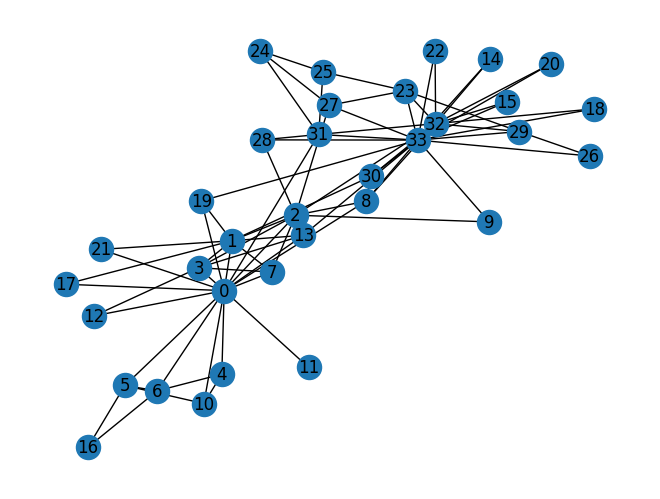

In [ ]:
# Visualize the graph
nx.draw(G, with_labels = True)

## Question 1: karate club network的 average degree(平均度)是多少(5分)

In [ ]:
def average_degree(num_edges, num_nodes):
  # TODO: Implement this function that takes number of edges
  # and number of nodes, and returns the average node degree of
  # the graph. Round the result to nearest integer (for example
  # 3.3 will be rounded to 3 and 3.7 will be rounded to 4)

  avg_degree = 0

  ############# Your code here ############
  avg_degree = round(2 * num_edges / num_nodes)
  #########################################

  return avg_degree

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
print("Average degree of karate club network is {}".format(avg_degree))

Average degree of karate club network is 5


## Question 2: karate club网络的平均聚类系数是多少k? (5分)

In [ ]:
def average_clustering_coefficient(G):
  # TODO: Implement this function that takes a nx.Graph
  # and returns the average clustering coefficient. Round
  # the result to 2 decimal places (for example 3.333 will
  # be rounded to 3.33 and 3.7571 will be rounded to 3.76)

  avg_cluster_coef = 0

  ############# Your code here ############
  ## Note:
  ## 1: Please use the appropriate NetworkX clustering function
  cluster_coef_ls = nx.clustering(G).values()
  avg_cluster_coef = sum(cluster_coef_ls) / len(cluster_coef_ls)
  avg_cluster_coef = round(avg_cluster_coef, 2)
  #########################################

  return avg_cluster_coef

avg_cluster_coef = average_clustering_coefficient(G)
print("Average clustering coefficient of karate club network is {}".format(avg_cluster_coef))

Average clustering coefficient of karate club network is 0.57


## Question 3: 在一次PageRank迭代之后，节点0 (id为0的节点)的PageRank值是多少? (5 Points)

PageRank使用网络的链接结构来衡量图中节点的重要性。来自重要页面的“vote”更有价值。特殊的，当一个重要程度为 $r_i$ 的页面 $i$ 具有 $d_i$ 个外部链接, 那么每个链接将会得到 $\frac{r_i}{d_i}$ 的“vote”. 因此一个页面 $j$的重要程度, 记为 $r_j$ ，是他所有链接的总和
$$r_j = \sum_{i \rightarrow j} \frac{r_i}{d_i}$$

, 其中 $d_i$ 是节点 $i$ 的出度.

PageRank算法(由Google使用)输出一个概率分布，表示随机浏览者点击链接到达任何特定页面的可能性。在每个时间步，随机的冲浪者有两个选择：
- $\beta$ 的概率随机跟随一个页面
- $1- \beta$ 的概率随机跳转到一个页面

因此，一个特定页面的重要性由下面的pagerank等式计算：
 $$r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}$$

请通过实现节点0的上述PageRank方程来完成代码块。



In [ ]:
def one_iter_pagerank(G, beta, r0, node_id):
  # TODO: Implement this function that takes a nx.Graph, beta, r0 and node id.
  # The return value r1 is one interation PageRank value for the input node.
  # Please round r1 to 2 decimal places.

  r1 = 0

  ############# Your code here ############
  ## Note:
  ## 1: You should not use nx.pagerank
  edge_ls = list(G.edges.keys())
  edge_ls = edge_ls + [(i[1], i[0]) for i in edge_ls] # no direction
  for edge in edge_ls:
    if edge[1] == node_id:
      r1 += beta * r0 / G.degree(edge[0])
  r1 += (1 - beta) / G.number_of_nodes()
  r1 = round(r1, 2)
  #########################################

  return r1

beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print("The PageRank value for node 0 after one iteration is {}".format(r1))

The PageRank value for node 0 after one iteration is 0.13


# 2 Graph to Tensor
我们将一起将图$G$转换为PyTorch tensor，这样我们就可以在图上执行机器学习。

## Setup
检查Pytorch是否安装好了

In [ ]:
import torch
print(torch.__version__)

2.2.1+cu121


## PyTorch tensor 基础

我们可以生成全0、1或随机值的PyTorch张量。

In [ ]:
# Generate 3 x 4 tensor with all ones
ones = torch.ones(3, 4)
print(ones)

# Generate 3 x 4 tensor with all zeros
zeros = torch.zeros(3, 4)
print(zeros)

# Generate 3 x 4 tensor with random values on the interval [0, 1)
random_tensor = torch.rand(3, 4)
print(random_tensor)

# Get the shape of the tensor
print(ones.shape)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0.7441, 0.3068, 0.3308, 0.2626],
        [0.2937, 0.2209, 0.7933, 0.4220],
        [0.9003, 0.9537, 0.2996, 0.8548]])
torch.Size([3, 4])


PyTorch张量包含一个数据类型`dtype`的元素。

In [ ]:
# Create a 3 x 4 tensor with all 32-bit floating point zeros
zeros = torch.zeros(3, 4, dtype=torch.float32)
print(zeros.dtype)

# Change the tensor dtype to 64-bit integer
zeros = zeros.type(torch.long)
print(zeros.dtype)

torch.float32
torch.int64


## Question 5: 获取karate club network的边列表并将其转换为 `torch.LongTensor`.  `pos_edge_index` tensor的 `torch.sum` 值是多少? (10 分)

In [ ]:
def graph_to_edge_list(G):
  # TODO: Implement the function that returns the edge list of
  # an nx.Graph. The returned edge_list should be a list of tuples
  # where each tuple is a tuple representing an edge connected
  # by two nodes.

  edge_list = []

  ############# Your code here ############
  edge_list = list(G.edges)
  #########################################

  return edge_list

def edge_list_to_tensor(edge_list):
  # TODO: Implement the function that transforms the edge_list to
  # tensor. The input edge_list is a list of tuples and the resulting
  # tensor should have the shape [2, len(edge_list)].

  edge_index = torch.tensor([])

  ############# Your code here ############
  edge_index = torch.tensor(edge_list).T
  #########################################

  return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


## Question 6: 请实现以下对负边进行采样的函数。然后回答哪些边(edge_1到edge_5)是karate club network中的负边?(10分)

“负”边是指图中不存在的边/链接。“负”一词是从链路预测中的“负抽样”借来的。这与边的权值无关。

例如，给定一条边(src, dst)，您应该检查(src, dst)和(dst, src)都不是图中的边。如果这些都成立，那么它就是一条负边。

In [ ]:
import random

def sample_negative_edges(G, num_neg_samples):
  # TODO: Implement the function that returns a list of negative edges.
  # The number of sampled negative edges is num_neg_samples. You do not
  # need to consider the corner case when the number of possible negative edges
  # is less than num_neg_samples. It should be ok as long as your implementation
  # works on the karate club network. In this implementation, self loops should
  # not be considered as either a positive or negative edge. Also, notice that
  # the karate club network is an undirected graph, if (0, 1) is a positive
  # edge, do you think (1, 0) can be a negative one?

  neg_edge_list = []

  ############# Your code here ############
  total_neg_edge_list = []
  edge_set = set(graph_to_edge_list(G))
  node_ls = list(G.nodes)
  num_nodes = len(node_ls)

  for i in range(0, num_nodes):
    for j in range(i+1, num_nodes):
      u = node_ls[i]
      v = node_ls[j]
      if (u, v) not in edge_set and (v, u) not in edge_set:
        total_neg_edge_list.append((u,v))

  random.shuffle(total_neg_edge_list)
  neg_edge_list = total_neg_edge_list[0:num_neg_samples]
  #########################################

  return neg_edge_list

# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

############# Your code here ############
## Note:
## 1: For each of the 5 edges, print whether it can be negative edge
edge_set = set(graph_to_edge_list(G))
temp_edge_ls = [edge_1, edge_2, edge_3, edge_4, edge_5]
for edge in temp_edge_ls:
  if edge in edge_set or (edge[1], edge[0]) in edge_set:
    print("No")
  else:
    print("Yes")
#########################################

The neg_edge_index tensor has shape torch.Size([2, 78])
No
Yes
No
No
Yes


# 3 节点表示学习

最后，我们将完成图的第一个学习算法:节点嵌入模型。


## Setup

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(torch.__version__)

2.2.1+cu121


为了编写我们自己的节点表示学习方法，我们将会大量使用[`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) 模块（pytorch版）. 我们来学习如何使用 `nn.Embedding`:

In [ ]:
# Initialize an embedding layer
# Suppose we want to have embedding for 4 items (e.g., nodes)
# Each item is represented with 8 dimensional vector

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


我们可以使用tensor下标从嵌入矩阵中选择项

In [ ]:
# Select an embedding in emb_sample
id = torch.LongTensor([1])
print(emb_sample(id))

# Select multiple embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# Get the shape of the embedding weight matrix
shape = emb_sample.weight.data.shape
print(shape)

# Overwrite the weight to tensor with all ones
emb_sample.weight.data = torch.ones(shape)

# Let's check if the emb is indeed initilized
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[-0.0762, -0.1327, -0.7885,  2.0849,  1.9557,  0.3924, -0.9828, -0.0908]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-0.0762, -0.1327, -0.7885,  2.0849,  1.9557,  0.3924, -0.9828, -0.0908],
        [-0.0852, -0.6875, -0.1764,  0.4720, -0.2742, -0.3483, -1.7361,  0.3859]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


现在来为我们已有的图创造embedding
- 我们想要karate club network 每个节点的 **16 dimensional** 向量表示
- 我们想用 **uniform distribution** （正态分布）初始化矩阵, 在 $[0, 1)$ 范围内. 建议使用 [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html).

In [ ]:
# Please do not change / reset the random seed
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
  # TODO: Implement this function that will create the node embedding matrix.
  # A torch.nn.Embedding layer will be returned. You do not need to change
  # the values of num_node and embedding_dim. The weight matrix of returned
  # layer should be initialized under uniform distribution.

  emb = None

  ############# Your code here ############
  emb = nn.Embedding(num_embeddings=num_node, embedding_dim=embedding_dim)
  shape = emb.weight.data.shape
  emb.weight.data = torch.randn(shape)
  #########################################

  return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# Print the embedding layer
print("Embedding: {}".format(emb))

# An example that gets the embeddings for node 0 and 3
print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[ 0.3467,  1.1960,  0.0507, -2.4047,  0.6637, -0.3969,  0.4049,  0.3415,
         -0.5956,  1.1019,  0.5539, -0.9509, -0.5039,  1.7359,  1.1365,  0.7353],
        [ 0.8533, -1.4188,  0.9830, -0.5387,  0.1378,  0.9247,  0.2938,  3.0301,
         -1.4259,  0.3364, -0.0607, -2.7828,  1.3489,  0.2684, -1.1277, -0.5994]],
       grad_fn=<EmbeddingBackward0>)


## 可视化初始节点表示
理解嵌入矩阵的一个好方法是在二维空间中可视化它。
在这里，我们实现了一个嵌入可视化功能。
我们首先使用PCA将嵌入的维数降至二维空间。
然后我们可视化每个点，用它所属的集群来着色。

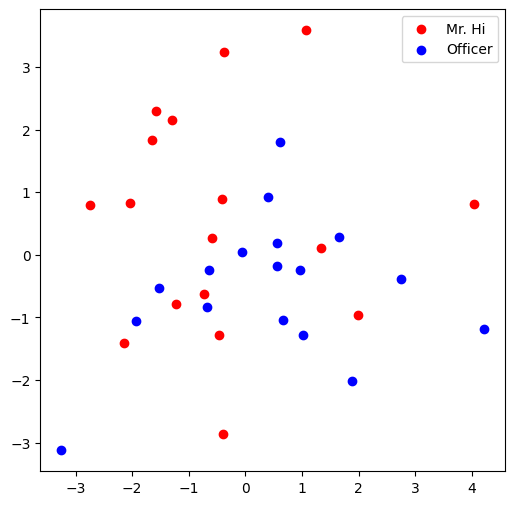

In [ ]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

## Question 7: 训练表示：你能得到的最好表示是什么?请在实验报告上记录最佳损失和准确性。(20分)

我们想要优化我们的嵌入来完成将边缘分类为正或负的任务。给定一条边和每个节点的嵌入，嵌入的点积，后面跟着一个sigmoid，应该给我们该边为正的可能性(sigmoid的输出>0.5)或负(sigmoid < 0.5)。

注意，我们使用的是您在前面的问题中编写的函数，以及在前面的单元格中初始化的变量。如果你遇到问题，确保你对问题1-6的答案是正确的。


In [ ]:
from torch.optim import SGD
import torch.nn as nn

def accuracy(pred, label):
  # TODO: Implement the accuracy function. This function takes the
  # pred tensor (the resulting tensor after sigmoid) and the label
  # tensor (torch.LongTensor). Predicted value greater than 0.5 will
  # be classified as label 1. Else it will be classified as label 0.
  # The returned accuracy should be rounded to 4 decimal places.
  # For example, accuracy 0.82956 will be rounded to 0.8296.

  accu = 0.0

  ############# Your code here ############
  accu = float(torch.sum(torch.round(pred) == label)) / label.shape[0]
  accu = round(accu, 4)
  #########################################

  return accu

def train(emb, loss_fn, sigmoid, train_label, train_edge):
  # TODO: Train the embedding layer here. You can also change epochs and
  # learning rate. In general, you need to implement:
  # (1) Get the embeddings of the nodes in train_edge
  # (2) Dot product the embeddings between each node pair
  # (3) Feed the dot product result into sigmoid
  # (4) Feed the sigmoid output into the loss_fn
  # (5) Print both loss and accuracy of each epoch
  # (6) Update the embeddings using the loss and optimizer
  # (as a sanity check, the loss should decrease during training)

  epochs = 500
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):

    ############# Your code here ############
    optimizer.zero_grad()
    node_embs = emb(train_edge)
    dot_prod = torch.sum(node_embs[0] * node_embs[1], -1)
    pred = sigmoid(dot_prod)
    loss = loss_fn(pred, train_label)
    accu = accuracy(pred.detach(), train_label.detach())
    print(f'epoch: {i}\tloss: {loss:.4f}\taccu: {accu}')
    loss.backward()
    optimizer.step()
    #########################################

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

print(pos_edge_index.shape)

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print(train_edge.shape)

train(emb, loss_fn, sigmoid, train_label, train_edge)

torch.Size([2, 78])
torch.Size([2, 156])
epoch: 0	loss: 1.9168	accu: 0.5128
epoch: 1	loss: 1.9059	accu: 0.5128
epoch: 2	loss: 1.8854	accu: 0.5128
epoch: 3	loss: 1.8563	accu: 0.5128
epoch: 4	loss: 1.8198	accu: 0.5192
epoch: 5	loss: 1.7770	accu: 0.5256
epoch: 6	loss: 1.7288	accu: 0.5256
epoch: 7	loss: 1.6763	accu: 0.5256
epoch: 8	loss: 1.6204	accu: 0.5256
epoch: 9	loss: 1.5617	accu: 0.5256
epoch: 10	loss: 1.5013	accu: 0.5321
epoch: 11	loss: 1.4397	accu: 0.5385
epoch: 12	loss: 1.3776	accu: 0.5641
epoch: 13	loss: 1.3155	accu: 0.5641
epoch: 14	loss: 1.2541	accu: 0.6026
epoch: 15	loss: 1.1936	accu: 0.6026
epoch: 16	loss: 1.1345	accu: 0.6154
epoch: 17	loss: 1.0770	accu: 0.6282
epoch: 18	loss: 1.0212	accu: 0.6282
epoch: 19	loss: 0.9673	accu: 0.6474
epoch: 20	loss: 0.9154	accu: 0.6538
epoch: 21	loss: 0.8656	accu: 0.6731
epoch: 22	loss: 0.8179	accu: 0.6859
epoch: 23	loss: 0.7724	accu: 0.6923
epoch: 24	loss: 0.7292	accu: 0.7051
epoch: 25	loss: 0.6883	accu: 0.7115
epoch: 26	loss: 0.6498	accu: 0.71

## 可视化最终的节点表示
在这里可视化节点最终表示，可以直观地将该图与之前的嵌入图进行比较。
训练后，你会发现这两个班的分离更加明显了。
这也是对代码实现的一个很好的完整性检查。

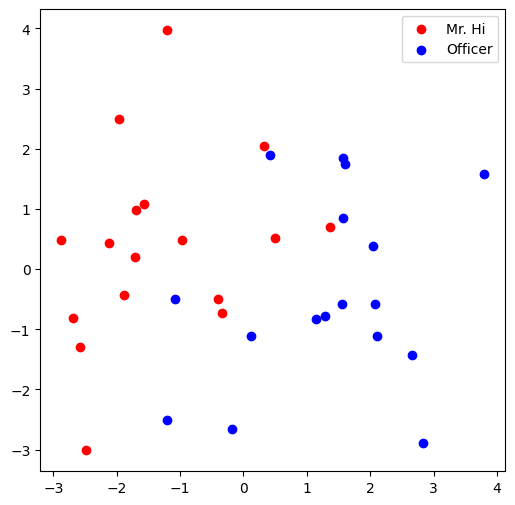

In [ ]:
# Visualize the final learned embedding
visualize_emb(emb)

# **Part 2 GNN**

在Part 2中，我们将使用PyTorch Geometric (PyG)构建我们自己的图神经网络，然后将该模型应用于两个Open graph Benchmark (OGB)数据集。这两个数据集将用于在两个不同的基于图的任务上对模型的性能进行基准测试:1)节点属性预测，预测单个节点的属性;2)图属性预测，预测整个图或子图的属性。

首先，我们将学习PyTorch Geometric如何将图存储为PyTorch张量。

然后，我们将使用`ogb`包加载和检查开放图形基准(OGB)数据集之一。OGB是一个现实的、大规模的、不同的基准数据集的集合，用于图上的机器学习。`ogb`包不仅为每个数据集提供数据加载器，还提供模型评估器。

最后，我们将使用PyTorch Geometric构建我们自己的图神经网络。然后，我们将在OGB节点属性预测和图属性预测任务上训练和评估我们的模型。


**注意**: 确保 **顺序运行每个section的代码**, 这样所有临时变量或包才能被保留到下个cell


# Device

可能需要gpu来加速图神经网络训练，可以在[google colab](https://colab.research.google.com/#/)上运行我们的脚本，里面有免费gpu

点击 `Runtime` 然后点击 `Change runtime type`. 将`hardware accelerator` 设置为 **GPU**.

# Setup
在Colab上安装PyG可能有点棘手。首先让我们检查你正在运行的PyTorch的版本

In [ ]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.2.1+cu121


下载PyG所需的软件包。确保您的torch版本与上面单元的输出相匹配。如果有任何问题，可以在[PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html)上找到

In [ ]:
# Install torch geometric
if 'IS_GRADESCOPE_ENV' not in os.environ:
  torch_version = str(torch.__version__)
  scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  !pip install torch-scatter -f $scatter_src
  !pip install torch-sparse -f $sparse_src
  !pip install torch-geometric
  !pip install ogb

Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 84.9 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manyl

# 1) PyTorch Geometric (Datasets and Data)


PyTorch Geometric有两个类用于存储和/或将图形转换为tensor格式。一个是`torch_geometric.dataset` ，其中包含各种常见的图形数据集。另一个是`torch_geometric.data `，它提供PyTorch张量中图形的数据处理。

在本节中，我们将学习如何使用`torch_geometric.dataset`和`torch_geometric.data`

## PyG Datasets

`torch_geometric.datasets` 类有很多常用的图数据集. 我们将使用一个示例数据集探索它的用法

In [ ]:
from torch_geometric.datasets import TUDataset

if 'IS_GRADESCOPE_ENV' not in os.environ:
  root = './enzymes'
  name = 'ENZYMES'

  # The ENZYMES dataset
  pyg_dataset= TUDataset(root, name)

  # You will find that there are 600 graphs in this dataset
  print(pyg_dataset)

Processing...


ENZYMES(600)


Done!


## Question 1: ENZYMES数据集中的类和特征的数量是多少?(5分)


In [ ]:
def get_num_classes(pyg_dataset):
  # TODO: Implement a function that takes a PyG dataset object
  # and returns the number of classes for that dataset.

  num_classes = 0

  ############# Your code here ############
  ## (~1 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful.
  num_classes = pyg_dataset.num_classes
  #########################################

  return num_classes

def get_num_features(pyg_dataset):
  # TODO: Implement a function that takes a PyG dataset object
  # and returns the number of features for that dataset.

  num_features = 0

  ############# Your code here ############
  ## (~1 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful.
  num_features = pyg_dataset.num_node_features
  #########################################

  return num_features

if 'IS_GRADESCOPE_ENV' not in os.environ:
  num_classes = get_num_classes(pyg_dataset)
  num_features = get_num_features(pyg_dataset)
  print("{} dataset has {} classes".format(name, num_classes))
  print("{} dataset has {} features".format(name, num_features))

ENZYMES dataset has 6 classes
ENZYMES dataset has 3 features


## PyG Data

每个PyG dataset 都存储一个 `torch_geometric.data.Data` 列表中的objects，其中每个 `torch_geometric.data.Data` object 都表示一个图，我们能轻松通过dataset的index找到其中的 `Data` object

有关`Data`对象中存储的内容等更多信息，请参阅[documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data).

## Question 2: 在ENZYMES数据集中索引为100的图的标签是什么?(5分)

In [ ]:
def get_graph_class(pyg_dataset, idx):
  # TODO: Implement a function that takes a PyG dataset object,
  # an index of a graph within the dataset, and returns the class/label
  # of the graph (as an integer).

  label = -1

  ############# Your code here ############
  ## (~1 line of code)
  label = pyg_dataset[idx].y.item()
  #########################################

  return label

# Here pyg_dataset is a dataset for graph classification
if 'IS_GRADESCOPE_ENV' not in os.environ:
  graph_0 = pyg_dataset[0]
  print(graph_0)
  idx = 100
  label = get_graph_class(pyg_dataset, idx)
  print('Graph with index {} has label {}'.format(idx, label))

Data(edge_index=[2, 168], x=[37, 3], y=[1])
Graph with index 100 has label 4


## Question 3: 索引为200的图有多少条边?(5分)

In [ ]:
def get_graph_num_edges(pyg_dataset, idx):
  # TODO: Implement a function that takes a PyG dataset object,
  # the index of a graph in the dataset, and returns the number of
  # edges in the graph (as an integer). You should not count an edge
  # twice if the graph is undirected. For example, in an undirected
  # graph G, if two nodes v and u are connected by an edge, this edge
  # should only be counted once.

  num_edges = 0

  ############# Your code here ############
  ## Note:
  ## 1. You can't return the data.num_edges directly
  ## 2. We assume the graph is undirected
  ## 3. Look at the PyG dataset built in functions
  ## (~4 lines of code)
  num_edges = pyg_dataset[idx].edge_index.shape[1] // 2
  #########################################

  return num_edges

if 'IS_GRADESCOPE_ENV' not in os.environ:
  idx = 200
  num_edges = get_graph_num_edges(pyg_dataset, idx)
  print('Graph with index {} has {} edges'.format(idx, num_edges))

Graph with index 200 has 53 edges


# 2) Open Graph Benchmark (OGB)

Open Graph Benchmark (OGB) 是一个现实的、大规模的、不同的基准数据集的集合，用于图上的机器学习。使用OGB Data Loader自动下载、处理和分割它的数据集。然后可以使用OGB评估器以统一的方式评估模型性能。

## Dataset and Data

OGB还支持PyG数据集和数据类。下面我们来看一下`ogbn-arxiv`数据集。

In [ ]:
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset

if 'IS_GRADESCOPE_ENV' not in os.environ:
  dataset_name = 'ogbn-arxiv'
  # Load the dataset and transform it to sparse tensor
  dataset = PygNodePropPredDataset(name=dataset_name,
                                  transform=T.ToSparseTensor())
  print('The {} dataset has {} graph'.format(dataset_name, len(dataset)))

  # Extract the graph
  data = dataset[0]
  print(data)

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:02<00:00, 32.25it/s]


Extracting dataset/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 1915.21it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 3569.62it/s]

Saving...



Done!


The ogbn-arxiv dataset has 1 graph
Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=1166243])


## Question 4: 在ogbn-arxiv图中有多少特征?(5分)

In [ ]:
def graph_num_features(data):
  # TODO: Implement a function that takes a PyG data object,
  # and returns the number of features in the graph (as an integer).

  num_features = 0

  ############# Your code here ############
  ## (~1 line of code)
  num_features = data.num_node_features
  #########################################

  return num_features

if 'IS_GRADESCOPE_ENV' not in os.environ:
  num_features = graph_num_features(data)
  print('The graph has {} features'.format(num_features))

The graph has 128 features


# 3) GNN: Node Property Prediction

在本节中，我们将使用PyTorch Geometric构建我们的第一个图神经网络。然后我们将其应用于节点属性预测(节点分类)任务。

具体来说，我们将使用GCN作为你的图神经网络的基础([Kipf et al. (2017)](https://arxiv.org/pdf/1609.02907.pdf)). 为此，我们将使用PyG内置的`GCNConv`层。

## Setup

In [ ]:
import torch
import pandas as pd
import torch.nn.functional as F
print(torch.__version__)

# The PyG built-in GCNConv
from torch_geometric.nn import GCNConv

import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

2.2.1+cu121


## Load and Preprocess the Dataset

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  dataset_name = 'ogbn-arxiv'
  dataset = PygNodePropPredDataset(name=dataset_name,
                                  transform=T.ToSparseTensor())
  data = dataset[0]

  # Make the adjacency matrix to symmetric
  data.adj_t = data.adj_t.to_symmetric()

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  # If you use GPU, the device should be cuda
  print('Device: {}'.format(device))

  data = data.to(device)
  split_idx = dataset.get_idx_split()
  train_idx = split_idx['train'].to(device)

Device: cuda


## GCN Model

现在我们将实现我们的GCN模型!

请按照下图实现`forward`功能。


![test](https://drive.google.com/uc?id=128AuYAXNXGg7PIhJJ7e420DoPWKb-RtL)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):
        # TODO: Implement a function that initializes self.convs,
        # self.bns, and self.softmax.

        super(GCN, self).__init__()

        # A list of GCNConv layers
        self.convs = None

        # A list of 1D batch normalization layers
        self.bns = None

        # The log softmax layer
        self.softmax = None

        ############# Your code here ############
        ## Note:
        ## 1. You should use torch.nn.ModuleList for self.convs and self.bns
        ## 2. self.convs has num_layers GCNConv layers
        ## 3. self.bns has num_layers - 1 BatchNorm1d layers
        ## 4. You should use torch.nn.LogSoftmax for self.softmax
        ## 5. The parameters you can set for GCNConv include 'in_channels' and
        ## 'out_channels'. For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        ## 6. The only parameter you need to set for BatchNorm1d is 'num_features'
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        ## (~10 lines of code)
        self.convs = torch.nn.ModuleList([GCNConv(input_dim, hidden_dim)]
                                        +[GCNConv(hidden_dim, hidden_dim) for i in range(num_layers-2)]
                                        +[GCNConv(hidden_dim, output_dim)])
        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim) for i in range(num_layers-1)])
        self.softmax = torch.nn.LogSoftmax()

        #########################################

        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        # TODO: Implement a function that takes the feature tensor x and
        # edge_index tensor adj_t and returns the output tensor as
        # shown in the figure.

        out = None

        ############# Your code here ############
        ## Note:
        ## 1. Construct the network as shown in the figure
        ## 2. torch.nn.functional.relu and torch.nn.functional.dropout are useful
        ## For more information please refer to the documentation:
        ## https://pytorch.org/docs/stable/nn.functional.html
        ## 3. Don't forget to set F.dropout training to self.training
        ## 4. If return_embeds is True, then skip the last softmax layer
        ## (~7 lines of code)
        num_layers = len(self.convs)
        for i in range(num_layers - 1):
            conv = self.convs[i]
            bn = self.bns[i]

            x = conv(x, adj_t)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.convs[num_layers-1](x, adj_t)
        if not self.return_embeds:
            x = self.softmax(x)
        out = x
        #########################################

        return out

In [ ]:
def train(model, data, train_idx, optimizer, loss_fn):
    # TODO: Implement a function that trains the model by
    # using the given optimizer and loss_fn.
    model.train()
    loss = 0

    ############# Your code here ############
    ## Note:
    ## 1. Zero grad the optimizer
    ## 2. Feed the data into the model
    ## 3. Slice the model output and label by train_idx
    ## 4. Feed the sliced output and label to loss_fn
    ## (~4 lines of code)
    optimizer.zero_grad()
    out = model(data.x, data.adj_t)
    loss = loss_fn(out[train_idx], data.y[train_idx].reshape(-1))
    #########################################

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# Test function here
@torch.no_grad()
def test(model, data, split_idx, evaluator, save_model_results=False):
    # TODO: Implement a function that tests the model by
    # using the given split_idx and evaluator.
    model.eval()

    # The output of model on all data
    out = None

    ############# Your code here ############
    ## (~1 line of code)
    ## Note:
    ## 1. No index slicing here
    out = model(data.x, data.adj_t)
    #########################################

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    if save_model_results:
      print ("Saving Model Predictions")

      data = {}
      data['y_pred'] = y_pred.view(-1).cpu().detach().numpy()

      df = pd.DataFrame(data=data)
      # Save locally as csv
      df.to_csv('ogbn-arxiv_node.csv', sep=',', index=False)


    return train_acc, valid_acc, test_acc

In [ ]:
# Please do not change the args
if 'IS_GRADESCOPE_ENV' not in os.environ:
  args = {
      'device': device,
      'num_layers': 3,
      'hidden_dim': 256,
      'dropout': 0.5,
      'lr': 0.01,
      'epochs': 100,
  }
  args

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  model = GCN(data.num_features, args['hidden_dim'],
              dataset.num_classes, args['num_layers'],
              args['dropout']).to(device)
  evaluator = Evaluator(name='ogbn-arxiv')

In [ ]:
# Please do not change these args
# Training should take <10min using GPU runtime
import copy
if 'IS_GRADESCOPE_ENV' not in os.environ:
  # reset the parameters to initial random value
  model.reset_parameters()

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  loss_fn = F.nll_loss

  best_model = None
  best_valid_acc = 0

  for epoch in range(1, 1 + args["epochs"]):
    loss = train(model, data, train_idx, optimizer, loss_fn)
    result = test(model, data, split_idx, evaluator)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 01, Loss: 4.0691, Train: 11.63%, Valid: 23.12% Test: 21.63%
Epoch: 02, Loss: 2.3559, Train: 20.04%, Valid: 19.88% Test: 25.44%
Epoch: 03, Loss: 1.9453, Train: 35.40%, Valid: 37.56% Test: 37.00%
Epoch: 04, Loss: 1.7756, Train: 38.81%, Valid: 38.42% Test: 36.38%
Epoch: 05, Loss: 1.6630, Train: 35.23%, Valid: 22.62% Test: 20.77%
Epoch: 06, Loss: 1.5829, Train: 34.61%, Valid: 20.43% Test: 19.04%
Epoch: 07, Loss: 1.5091, Train: 33.40%, Valid: 21.42% Test: 21.05%
Epoch: 08, Loss: 1.4434, Train: 34.42%, Valid: 23.78% Test: 22.33%
Epoch: 09, Loss: 1.3966, Train: 36.53%, Valid: 26.88% Test: 26.04%
Epoch: 10, Loss: 1.3634, Train: 39.42%, Valid: 32.29% Test: 33.35%
Epoch: 11, Loss: 1.3350, Train: 42.45%, Valid: 39.01% Test: 44.03%
Epoch: 12, Loss: 1.3045, Train: 43.84%, Valid: 39.67% Test: 44.83%
Epoch: 13, Loss: 1.2717, Train: 45.35%, Valid: 41.38% Test: 46.96%
Epoch: 14, Loss: 1.2540, Train: 48.77%, Valid: 47.38% Test: 51.97%
Epoch: 15, Loss: 1.2346, Train: 52.75%, Valid: 52.40% Test: 54

## Question 5: 你的`best_model`验证和测试精度是多少?(20分)

运行下面的单元格以查看最佳模型的结果，并将模型的预测保存到一个名为*ogbn-arxiv_node.csv*的文件中。在实验报告上报告结果。

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  best_result = test(best_model, data, split_idx, evaluator, save_model_results=True)
  train_acc, valid_acc, test_acc = best_result
  print(f'Best model: '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Saving Model Predictions
Best model: Train: 73.61%, Valid: 71.75% Test: 70.71%


# 4) GNN: Graph Property Prediction

在本节中，我们将创建一个用于图属性预测(图分类)的图神经网络。

## Load and preprocess the dataset

In [ ]:
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.data import DataLoader
from tqdm.notebook import tqdm

if 'IS_GRADESCOPE_ENV' not in os.environ:
  # Load the dataset
  dataset = PygGraphPropPredDataset(name='ogbg-molhiv')

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print('Device: {}'.format(device))

  split_idx = dataset.get_idx_split()

  # Check task type
  print('Task type: {}'.format(dataset.task_type))

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 57862.67it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:02<00:00, 20313.15it/s]


Saving...
Device: cuda
Task type: binary classification


Done!


In [ ]:
# Load the dataset splits into corresponding dataloaders
# We will train the graph classification task on a batch of 32 graphs
# Shuffle the order of graphs for training set
if 'IS_GRADESCOPE_ENV' not in os.environ:
  train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=0)
  valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False, num_workers=0)
  test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False, num_workers=0)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  # Please do not change the args
  args = {
      'device': device,
      'num_layers': 5,
      'hidden_dim': 256,
      'dropout': 0.5,
      'lr': 0.001,
      'epochs': 30,
  }
  args

## Graph Prediction Model

### Graph Mini-Batching
在深入研究实际模型之前，我们先介绍图的mini-batch概念。为了并行处理小批图，PyG将这些图组合成一个单独的断开连接的图数据对象(*torch_geometry.data. Batch*)。*torch_geometric.data.Batch*继承自*torch_geometry.data.Data*(前面介绍过)，并包含一个名为`batch`的附加属性。

`batch`属性是一个向量，将每个节点映射到mini-batch中相应图的索引:

    batch = [0, ..., 0, 1, ..., n - 2, n - 1, ..., n - 1]

这个属性对于关联每个节点所属的图是至关重要的，并且可以用于对每个图的节点嵌入分别进行平均以计算图级嵌入。



### Implemention
现在，我们有了实现GCN图预测模型的所有工具!

我们将重用现有的GCN模型来生成`node_embeddings`，然后在节点上使用`Global Pooling`来创建可用于预测每个图的属性的图级嵌入。请记住，`batch`属性对于在我们的小批图上执行全局池至关重要。

In [ ]:
from ogb.graphproppred.mol_encoder import AtomEncoder
from torch_geometric.nn import global_add_pool, global_mean_pool

### GCN to predict graph property
class GCN_Graph(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout):
        super(GCN_Graph, self).__init__()

        # Load encoders for Atoms in molecule graphs
        self.node_encoder = AtomEncoder(hidden_dim)

        # Node embedding model
        # Note that the input_dim and output_dim are set to hidden_dim
        self.gnn_node = GCN(hidden_dim, hidden_dim,
            hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = None

        ############# Your code here ############
        ## Note:
        ## 1. Initialize self.pool as a global mean pooling layer
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        self.pool = global_add_pool
        #########################################

        # Output layer
        self.linear = torch.nn.Linear(hidden_dim, output_dim)


    def reset_parameters(self):
      self.gnn_node.reset_parameters()
      self.linear.reset_parameters()

    def forward(self, batched_data):
        # TODO: Implement a function that takes as input a
        # mini-batch of graphs (torch_geometric.data.Batch) and
        # returns the predicted graph property for each graph.
        #
        # NOTE: Since we are predicting graph level properties,
        # your output will be a tensor with dimension equaling
        # the number of graphs in the mini-batch


        # Extract important attributes of our mini-batch
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        embed = self.node_encoder(x)

        out = None

        ############# Your code here ############
        ## Note:
        ## 1. Construct node embeddings using existing GCN model
        ## 2. Use the global pooling layer to aggregate features for each individual graph
        ## For more information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        ## 3. Use a linear layer to predict each graph's property
        ## (~3 lines of code)
        node_embed = self.gnn_node(embed, edge_index)
        graph_embed = self.pool(node_embed, batch)
        out = self.linear(graph_embed)
        #########################################

        return out

In [ ]:
def train(model, device, data_loader, optimizer, loss_fn):
    # TODO: Implement a function that trains your model by
    # using the given optimizer and loss_fn.
    model.train()
    loss = 0

    for step, batch in enumerate(tqdm(data_loader, desc="Iteration")):
      batch = batch.to(device)

      if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
          pass
      else:
        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y

        ############# Your code here ############
        ## Note:
        ## 1. Zero grad the optimizer
        ## 2. Feed the data into the model
        ## 3. Use `is_labeled` mask to filter output and labels
        ## 4. You may need to change the type of label to torch.float32
        ## 5. Feed the output and label to the loss_fn
        ## (~3 lines of code)
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out[is_labeled], batch.y[is_labeled].float())
        #########################################

        loss.backward()
        optimizer.step()

    return loss.item()

In [ ]:
# The evaluation function
def eval(model, device, loader, evaluator, save_model_results=False, save_file=None):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    if save_model_results:
        print ("Saving Model Predictions")

        # Create a pandas dataframe with a two columns
        # y_pred | y_true
        data = {}
        data['y_pred'] = y_pred.reshape(-1)
        data['y_true'] = y_true.reshape(-1)

        df = pd.DataFrame(data=data)
        # Save to csv
        df.to_csv('ogbg-molhiv_graph_' + save_file + '.csv', sep=',', index=False)

    return evaluator.eval(input_dict)

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  model = GCN_Graph(args['hidden_dim'],
              dataset.num_tasks, args['num_layers'],
              args['dropout']).to(device)
  evaluator = Evaluator(name='ogbg-molhiv')

In [ ]:
# Please do not change these args
# Training should take <10min using GPU runtime
import copy

if 'IS_GRADESCOPE_ENV' not in os.environ:
  model.reset_parameters()

  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
  loss_fn = torch.nn.BCEWithLogitsLoss()

  best_model = None
  best_valid_acc = 0

  for epoch in range(1, 1 + args["epochs"]):
    print('Training...')
    loss = train(model, device, train_loader, optimizer, loss_fn)

    print('Evaluating...')
    train_result = eval(model, device, train_loader, evaluator)
    val_result = eval(model, device, valid_loader, evaluator)
    test_result = eval(model, device, test_loader, evaluator)

    train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[dataset.eval_metric]
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 01, Loss: 0.0135, Train: 66.24%, Valid: 64.45% Test: 59.32%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 02, Loss: 0.0017, Train: 69.10%, Valid: 65.19% Test: 59.83%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 03, Loss: 0.0240, Train: 70.92%, Valid: 65.08% Test: 61.16%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 04, Loss: 0.0413, Train: 74.94%, Valid: 68.64% Test: 66.08%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 05, Loss: 0.0651, Train: 73.48%, Valid: 68.40% Test: 71.03%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 06, Loss: 1.8165, Train: 67.84%, Valid: 70.24% Test: 71.25%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 07, Loss: 0.0209, Train: 70.35%, Valid: 65.21% Test: 68.18%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 08, Loss: 0.2057, Train: 76.48%, Valid: 70.52% Test: 73.12%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 09, Loss: 0.1538, Train: 75.99%, Valid: 77.09% Test: 73.98%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.2746, Train: 76.08%, Valid: 65.82% Test: 71.02%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 11, Loss: 1.0856, Train: 74.26%, Valid: 67.49% Test: 67.83%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.0213, Train: 77.31%, Valid: 71.75% Test: 72.01%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.0342, Train: 77.86%, Valid: 72.45% Test: 72.80%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.0343, Train: 77.49%, Valid: 75.87% Test: 74.39%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.0307, Train: 79.35%, Valid: 76.67% Test: 75.42%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.0178, Train: 78.53%, Valid: 67.07% Test: 73.44%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.0183, Train: 79.22%, Valid: 76.74% Test: 72.96%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.0241, Train: 79.16%, Valid: 75.56% Test: 73.76%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.0505, Train: 80.24%, Valid: 78.03% Test: 75.16%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.0438, Train: 80.58%, Valid: 74.92% Test: 76.40%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.0544, Train: 79.96%, Valid: 74.60% Test: 73.38%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.0259, Train: 80.25%, Valid: 78.36% Test: 71.35%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.0106, Train: 80.78%, Valid: 73.14% Test: 75.57%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.0146, Train: 81.26%, Valid: 78.38% Test: 76.48%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.0330, Train: 80.55%, Valid: 79.34% Test: 76.66%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.0151, Train: 81.09%, Valid: 77.54% Test: 72.55%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.6658, Train: 80.96%, Valid: 78.32% Test: 75.70%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.0172, Train: 82.08%, Valid: 79.96% Test: 76.39%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.0276, Train: 81.66%, Valid: 80.27% Test: 77.28%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.0127, Train: 81.51%, Valid: 80.46% Test: 76.46%


## Question 6: 你的`best_model`验证和测试ROC-AUC分数是多少?(20分)

运行下面的单元格以查看最佳模型的结果，并将模型的预测保存在名为*ogbg-molhiv_graph_[valid,test].csv*的文件中。在实验报告上报告结果。

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  train_auroc = eval(best_model, device, train_loader, evaluator)[dataset.eval_metric]
  valid_auroc = eval(best_model, device, valid_loader, evaluator, save_model_results=True, save_file="valid")[dataset.eval_metric]
  test_auroc  = eval(best_model, device, test_loader, evaluator, save_model_results=True, save_file="test")[dataset.eval_metric]

  print(f'Best model: '
      f'Train: {100 * train_auroc:.2f}%, '
      f'Valid: {100 * valid_auroc:.2f}% '
      f'Test: {100 * test_auroc:.2f}%')

Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Saving Model Predictions


Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Saving Model Predictions
Best model: Train: 81.51%, Valid: 80.46% Test: 76.46%


## Question 7 (可选):在Pytorch Geometric中使用另外两个全局池化层进行实验。